In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import mixed_precision

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1fcd1f2f-9ee2-2e6d-0a3d-fba50c76dd2b)


In [3]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

--2022-08-10 13:11:11--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18407 (18K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  17.98K  --.-KB/s    in 0s      

2022-08-10 13:11:12 (35.2 MB/s) - ‘helper_functions.py’ saved [18407/18407]



In [4]:
from helper_functions import plot_loss_curves, compare_historys, create_data_augmented_layer_for_model, load_and_prep_image, make_confusion_matrix, make_confusion_matrix_for_larger_dataset

In [6]:
(train_data, test_data), ds_info= tfds.load(name="food101", split=["train", "validation"], shuffle_files=True, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete820MS7/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incomplete820MS7/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [9]:
class_names= ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [10]:
len(class_names)

101

In [11]:
CLASS_COUNT= len(class_names)

In [12]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple, tf.cast() changes the dtype intor float32.

In [13]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [14]:
test_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [15]:
train_data= train_data.map(map_func= preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
train_data= train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data= test_data.map(preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
test_data= test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [17]:
from helper_functions import  create_tensorboard_callback, model_check_point_callback, create_early_stopping_callback, reduce_learning_rate_callback

In [18]:
checkpoint_path= 'checkpoints/feature_extraction'
checkpoint_callback= model_check_point_callback(checkpoint_path, save_weights_only=True, save_best_only=True, monitor="val_accuracy")
tensorboard_callback= create_tensorboard_callback("transfer_learning", "Food101_full_dataset_feature_extraction")

Saving TensorBoard log files to: transfer_learning/Food101_full_dataset_feature_extraction/20220810-132312


In [19]:
mixed_precision.set_global_policy(policy="mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [20]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [21]:
# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [23]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [24]:
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False flo

In [25]:
history_101_food_classes_feature_extract = model.fit(train_data, epochs=3,steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)),callbacks=[tensorboard_callback, checkpoint_callback])

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8230 - accuracy: 0.5577
Epoch 1: val_accuracy improved from -inf to 0.67797, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 217s 83ms/step - loss: 1.8230 - accuracy: 0.5577 - val_loss: 1.2255 - val_accuracy: 0.6780
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2928 - accuracy: 0.6667
Epoch 2: val_accuracy improved from 0.67797 to 0.70869, saving model to checkpoints/feature_extraction
2368/2368 [==============================] - 193s 80ms/step - loss: 1.2928 - accuracy: 0.6667 - val_loss: 1.1254 - val_accuracy: 0.7087
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1425 - accuracy: 0.7014
Epoch 3: val_accuracy did not improve from 0.70869
2368/2368 [==============================] - 174s 73ms/step - loss: 1.1425 - accuracy: 0.7014 - val_loss: 1.0864 - val_accuracy: 0.7071


In [26]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 51s 64ms/step - loss: 1.0870 - accuracy: 0.7085


[1.0869632959365845, 0.7084752321243286]

In [27]:
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [29]:
cloned_model.load_weights(checkpoint_path)

In [30]:
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [31]:
results_cloned_model_with_loaded_weights = cloned_model.evaluate(test_data)

790/790 [==============================] - 52s 63ms/step - loss: 1.7579 - accuracy: 0.5392


In [32]:
results_feature_extract_model == results_cloned_model_with_loaded_weights

False

In [33]:
np.allclose(results_feature_extract_model, results_cloned_model_with_loaded_weights)

False

In [34]:
for layer in cloned_model.layers[1].layers[:20]: # check only the first 20 layers to save space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [35]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


In [36]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [37]:
result_loaded_saved_model= loaded_saved_model.evaluate(test_data)
result_loaded_saved_model

790/790 [==============================] - 53s 64ms/step - loss: 1.0870 - accuracy: 0.7085


[1.0869643688201904, 0.7084752321243286]

In [38]:
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 True float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False floa

In [39]:
results_feature_extract_model == result_loaded_saved_model

False

In [40]:
np.allclose(results_feature_extract_model, result_loaded_saved_model)

True

In [41]:
for layer in loaded_saved_model.layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2123bf6290> input_layer True
<keras.engine.functional.Functional object at 0x7f212357c8d0> efficientnetb0 False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f21251c97d0> pooling_layer True
<keras.layers.core.dense.Dense object at 0x7f2125258cd0> dense True
<keras.layers.core.activation.Activation object at 0x7f2123cf4410> softmax_float32 True


In [42]:
for layer in loaded_saved_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.dtype, layer.dtype_policy, layer.trainable)

input_layer float32 <Policy "float32"> True
efficientnetb0 float32 <Policy "mixed_float16"> True
pooling_layer float32 <Policy "mixed_float16"> True
dense float32 <Policy "mixed_float16"> True
softmax_float32 float32 <Policy "float32"> True


In [43]:
for layer in loaded_saved_model.layers[1].layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2123cfbb10> input_1 True
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f21232cbf50> rescaling True
<keras.layers.preprocessing.normalization.Normalization object at 0x7f21232d8ed0> normalization True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f212524cf90> stem_conv_pad True
<keras.layers.convolutional.Conv2D object at 0x7f212524c450> stem_conv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f21251aa1d0> stem_bn True
<keras.layers.core.activation.Activation object at 0x7f21233e4690> stem_activation True
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f21252b5110> block1a_dwconv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f21252a68d0> block1a_bn True
<keras.layers.core.activation.Activation object at 0x7f2123419990> block1a_activation True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2123419650> block1

In [44]:
for layer in loaded_saved_model.layers[1].layers:
  if layer.trainable == False:
    print(layer, layer.name, layer.trainable)

In [45]:
for layer in loaded_saved_model.layers[1].layers:
  if layer.trainable == True:
    print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f2123cfbb10> input_1 True
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f21232cbf50> rescaling True
<keras.layers.preprocessing.normalization.Normalization object at 0x7f21232d8ed0> normalization True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f212524cf90> stem_conv_pad True
<keras.layers.convolutional.Conv2D object at 0x7f212524c450> stem_conv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f21251aa1d0> stem_bn True
<keras.layers.core.activation.Activation object at 0x7f21233e4690> stem_activation True
<keras.layers.convolutional.DepthwiseConv2D object at 0x7f21252b5110> block1a_dwconv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f21252a68d0> block1a_bn True
<keras.layers.core.activation.Activation object at 0x7f2123419990> block1a_activation True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2123419650> block1

In [46]:
create_tensorboard_callback_fine_tuning= create_tensorboard_callback("transfer_learning", "fine_tuning_all_data_with_all_layers_unfrozen")
checkpoint_path_fine_tuning= 'checkpoints_fine_tuning/fine_tuning'
checkpoint_callback_fine_tuning= model_check_point_callback(checkpoint_path_fine_tuning, save_weights_only=True, save_best_only=True, monitor="val_accuracy")
early_stopping_callback= create_early_stopping_callback(monitor="val_loss", patience=3)
reduce_lr_callback= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/fine_tuning_all_data_with_all_layers_unfrozen/20220810-133734


In [47]:
loaded_saved_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [48]:
history_fine_tuning= loaded_saved_model.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps= int(0.15 * len(test_data)), callbacks=[create_tensorboard_callback_fine_tuning, checkpoint_callback_fine_tuning, early_stopping_callback, reduce_lr_callback])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9231 - accuracy: 0.7528
Epoch 1: val_accuracy improved from -inf to 0.77357, saving model to checkpoints_fine_tuning/fine_tuning
2368/2368 [==============================] - 357s 144ms/step - loss: 0.9231 - accuracy: 0.7528 - val_loss: 0.8007 - val_accuracy: 0.7736 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.8392
Epoch 2: val_accuracy improved from 0.77357 to 0.78284, saving model to checkpoints_fine_tuning/fine_tuning
2368/2368 [==============================] - 338s 142ms/step - loss: 0.5776 - accuracy: 0.8392 - val_loss: 0.7994 - val_accuracy: 0.7828 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3286 - accuracy: 0.9072
Epoch 3: val_accuracy improved from 0.78284 to 0.78310, saving model to checkpoints_fine_tuning/fine_tuning
2368/2368 [==============================] - 338s 142ms/step - loss: 0.328

In [49]:
loaded_saved_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [50]:
result_fine_tuned=loaded_saved_model.evaluate(test_data)
result_fine_tuned

790/790 [==============================] - 50s 63ms/step - loss: 1.0546 - accuracy: 0.7989


[1.0546395778656006, 0.798851490020752]

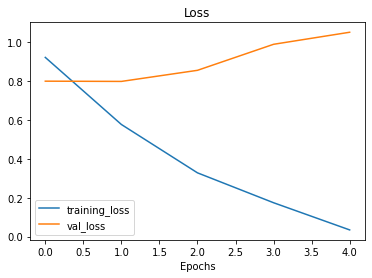

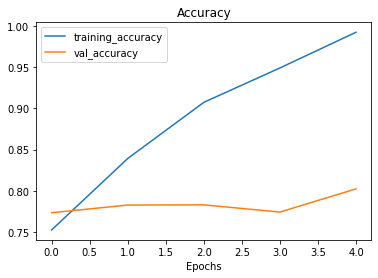

In [51]:
plot_loss_curves(history_fine_tuning)

In [52]:
save_dir = "07_efficientnetb0_fine_tuning_model_mixed_precision"
loaded_saved_model.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuning_model_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuning_model_mixed_precision/assets


In [53]:
loaded_saved_model_1= tf.keras.models.load_model(save_dir)

In [54]:
result_loaded_saved_model_1= loaded_saved_model_1.evaluate(test_data)
result_loaded_saved_model_1

790/790 [==============================] - 55s 67ms/step - loss: 1.0546 - accuracy: 0.7989


[1.0546386241912842, 0.798851490020752]

In [55]:
loaded_saved_model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 4,136,929
Non-train

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "Fine-Tuning of all 101 classes of Food101 Dataset" \
--description "Transfer Learning on the Food101 dataset with Fine-Tuning the EfficientNetB0 model to beat the 77% accuracy score on DeepFood paper" \
--one_shot

## To-Do

* Fix Overfitting
* Evaluate the model